In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip3 install vncorenlp
!pip install -q emoji

     |████████████████████████████████| 2.7MB 14.7MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=e837b1b9e559cd4b665a31e4e7c887b528515d316976fb605ca17dd0a68a8fd0
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 133kB 15.3MB/s 


In [ ]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# Pho2vec 300 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

# Pho2vec 100 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_100dims.zip 
# !mv word2vec_vi_words_100dims.zip /content/drive/MyDrive/KTDLTT/src/pho2vec
# !unzip -o "/content/drive/MyDrive/KTDLTT/src/pho2vec/word2vec_vi_words_100dims.zip"

# IMPORT LIBRARY AND PATH DATASET

In [ ]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# import tensorflow as tf
# # from transformers import TFAutoModel
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU, TimeDistributed, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from sklearn.metrics import matthews_corrcoef, confusion_matrix
# from sklearn import metrics
# from sklearn.utils import shuffle
# from official.nlp import optimization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.train import CheckpointOptions
# from tensorflow.keras.optimizers import Adam

np.random.seed(7)

In [ ]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSFC_sentiment/ML_pre/images')
MODEL_PATH = os.path.join(path_root, 'model/VSFC_sentiment/ML_pre')
name_model = 'VSFC_sent_pre_'

path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')
path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')

# DATA LOADER AND PREPROCESSING

## Data loader

In [ ]:
def read_txt(path):
  with open(path, 'r', encoding='utf-8') as f:
    return [elem.replace('\n', '') for elem in f.readlines()]

df_train = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_train.loc[:, 'sents'] = read_txt(path_VSFC_train_sents)
df_train.loc[:, 'sentiments'] = read_txt(path_VSFC_train_sentiments)
df_train.loc[:, 'topics'] = read_txt(path_VSFC_train_topics)

df_test = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_test.loc[:, 'sents'] = read_txt(path_VSFC_test_sents)
df_test.loc[:, 'sentiments'] = read_txt(path_VSFC_test_sentiments)
df_test.loc[:, 'topics'] = read_txt(path_VSFC_test_topics)

df_dev = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_dev.loc[:, 'sents'] = read_txt(path_VSFC_dev_sents)
df_dev.loc[:, 'sentiments'] = read_txt(path_VSFC_dev_sentiments)
df_dev.loc[:, 'topics'] = read_txt(path_VSFC_dev_topics)

df_train = df_train.astype({"sentiments": "int", "topics": "int", 'sents': "string"})
df_test = df_test.astype({"sentiments": "int", "topics": "int", 'sents': "string"})
df_dev = df_dev.astype({"sentiments": "int", "topics": "int", 'sents': "string"})

### Preprecessing Vietnamese texts

In [ ]:
# https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb
# https://nguyenvanhieu.vn/phan-loai-van-ban-tieng-viet
import regex as re
import emoji

### Standardize unicode 

In [ ]:
def convert_unicode(txt):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')
    
    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], txt
    )

### Standardize accent typing

In [ ]:
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]
for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)

In [ ]:
def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True

In [ ]:
def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)

In [ ]:
def standardize_sentence_typing(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

### Normalize acronyms

In [ ]:
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',
     
    'sz': 'cỡ', 'size': 'cỡ', 
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá', 
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được', 
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng', 
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng', 
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng', 
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt', 
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ', 
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp', 
    'xau': 'xấu', 'sấu': 'xấu', 
     
    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo', 
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài', 

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực', 
    '😔': 'tiêu cực', '😓': 'tiêu cực', 
    '⭐': 'star', '*': 'star', '🌟': 'star',
}
with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()

--2021-06-24 18:09:33--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0s      

2021-06-24 18:09:33 (67.4 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [ ]:
import string
def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word])
    return ' '.join(words)

### Word segmentation

In [ ]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def word_segmentation(row):
  row = annotator.tokenize(row)
  return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

### Combine all

In [ ]:
def text_preprocess(text):
    text = re.sub(r'<[^>]*>', '', text) # Remove HTML code
    text = convert_unicode(text) 
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) 
    text = re.sub(
        r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',
        ' ', # Remove unnecessary characters
        text
    )
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    text = emoji.demojize(text) # Remove Emojis
    return text

In [ ]:
df_train.loc[:, 'sents'] = df_train.loc[:, 'sents'].apply(text_preprocess)
df_test.loc[:, 'sents'] = df_test.loc[:, 'sents'].apply(text_preprocess)
df_dev.loc[:, 'sents'] = df_dev.loc[:, 'sents'].apply(text_preprocess)

In [ ]:
df_train.head(5)

,sents,sentiments,topics
0,slide giáo_trình đầy_đủ,2,1
1,nhiệt_tình giảng_dạy gần_gũi với sinh_viên,2,0
2,đi học đầy_đủ full điểm chuyên_cần,0,1
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...,0,0
4,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...,2,0


## Embedding word using PhoW2V

In [ ]:
# # Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [ ]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['sents'])
word_index = tokenizer.word_index

In [ ]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [ ]:
X_train = df_train['sents']
X_test = df_test['sents']
X_dev = df_dev['sents']

In [ ]:
X_train_token = prepare_input(X_train, tokenizer)
Y_train = np.array(df_train['sentiments'].tolist())#

X_dev_token = prepare_input(X_dev, tokenizer)
Y_dev = np.array(df_dev['sentiments'].tolist())#.reshape(-1,1)

X_test_token = prepare_input(X_test, tokenizer)
Y_test = np.array(df_test['sentiments'].tolist())#.reshape(-1,1)

In [ ]:
# # Create embedding matrix 
# def create_embedding(word_index, embedding_dict, EMBEDDING_DIM=100):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_pre_VSFC.npy'), embedding_matrix)

In [ ]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_pre_VSFC.npy'))

In [ ]:
def word2vec_sentence(embedding_matrix, data_matrix, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=300):
    embedding = np.random.random([data_matrix.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM])
    for idx, data_vector in enumerate(data_matrix):
      for idy, data_vec in enumerate(data_vector):
          embedding[idx][idy] = embedding_matrix[data_vec]
    return embedding

In [ ]:
X_train_input = word2vec_sentence(embedding_matrix, X_train_token)
X_train_input = X_train_input.reshape(X_train_input.shape[0], X_train_input.shape[1] * X_train_input.shape[2])

X_dev_input = word2vec_sentence(embedding_matrix, X_dev_token)
X_dev_input = X_dev_input.reshape(X_dev_input.shape[0], X_dev_input.shape[1] * X_dev_input.shape[2])

X_test_input =  word2vec_sentence(embedding_matrix, X_test_token)
X_test_input = X_test_input.reshape(X_test_input.shape[0], X_test_input.shape[1] * X_test_input.shape[2])

X_train_input.shape

(11426, 30000)

# Fine-tuning with TensorFlow

## Define the model

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn import naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
name_model_nvpho = name_model + 'nv_pho'

model = MultinomialNB()
model.fit(X_train_input, Y_train)
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test_input)
metric_nvpho = classification_report(Y_test, y_pred, output_dict=True) 
print(classification_report(Y_test, y_pred, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.6438    0.4606    0.5370      1409
           1     0.0916    0.6108    0.1593       167
           2     0.6284    0.4126    0.4981      1590

    accuracy                         0.4444      3166
   macro avg     0.4546    0.4947    0.3981      3166
weighted avg     0.6069    0.4444    0.4976      3166



In [ ]:
name_model_nvtfidf = name_model + 'nv_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', naive_bayes.MultinomialNB()))
naive = Pipeline(steps)
naive.fit(X_train, Y_train)
y_pred_nv = naive.predict(X_test)

print("\n Evaluating Model ... \n")
metric_nvtfidf = classification_report(Y_test, y_pred_nv, output_dict=True) 
print(classification_report(Y_test, y_pred_nv, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.8100    0.9588    0.8781      1409
           1     0.6667    0.0120    0.0235       167
           2     0.9224    0.8673    0.8940      1590

    accuracy                         0.8629      3166
   macro avg     0.7997    0.6127    0.5986      3166
weighted avg     0.8589    0.8629    0.8410      3166



In [ ]:
name_model_svm = name_model + 'svm_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', svm.SVC(probability=True, kernel="poly", class_weight="balanced")))
clf = Pipeline(steps)
clf.fit(X_train, Y_train)
y_pred_svm = clf.predict(X_test)

print("\n Evaluating Model ... \n")
metric_svm = classification_report(Y_test, y_pred_svm, output_dict=True) 
print(classification_report(Y_test, y_pred_svm, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.8061    0.9681    0.8797      1409
           1     0.4375    0.1257    0.1953       167
           2     0.9432    0.8459    0.8919      1590

    accuracy                         0.8623      3166
   macro avg     0.7289    0.6466    0.6557      3166
weighted avg     0.8555    0.8623    0.8497      3166



# Predict on test data

In [ ]:
import joblib

def save_model(model, metric, name_model):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_model_ = name_model + '_' + str(f1).replace('.', '') + '.pkl'
  joblib.dump(model, os.path.join(MODEL_PATH, name_model_))
 
save_model(model, metric_nvpho, name_model_nvpho)
save_model(naive, metric_nvtfidf, name_model_nvtfidf)
save_model(clf, metric_svm, name_model_svm)

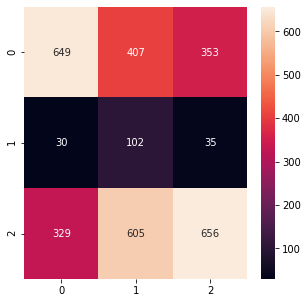

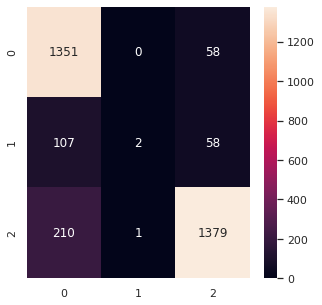

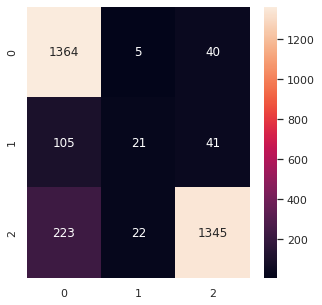

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(Y_test, y_pred, metric_nvpho, name_model_nvpho)
_confusion_matrix(Y_test, y_pred_nv, metric_nvtfidf, name_model_nvtfidf)
_confusion_matrix(Y_test, y_pred_svm, metric_svm, name_model_svm)

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score¶
print("Naive + Pho2WV:", f1_score(Y_test, y_pred, average='micro'))
print("Naive + Pho2WV:", recall_score(Y_test, y_pred, average='micro'))
print("Naive + Pho2WV:", precision_score¶(Y_test, y_pred, average='micro'))

print("Naive + TF-IDF:", f1_score(Y_test, y_pred_nv, average='micro'))
print("Naive + TF-IDF:", recall_score(Y_test, y_pred_nv, average='micro'))
print("Naive + TF-IDF:", precision_score¶(Y_test, y_pred_nv, average='micro'))

print("SVM + TF-IDF:", f1_score(Y_test, y_pred_svm, average='micro'))
print("SVM + TF-IDF:", recall_score(Y_test, y_pred_svm, average='micro'))
print("SVM + TF-IDF:", precision_score¶(Y_test, y_pred_svm, average='micro'))

Naive + Pho2WV: 0.44440934933670245
Naive + TF-IDF: 0.8629185091598233
SVM + TF-IDF: 0.8622867972204674
